Jon Nordby <jonnord@nmbu.no>


## Background
The article compares the 

### Insertion sort



### Merge sort
 
### Quicksort
### Heapsort


### Insertion sort
### Merge sort
 
### Quicksort
### Heapsort
    

### Summary of expected execution times

Best, Average, Worst

Insertion sort 	$n$ | $n^{2}$ | $n^{2}$

Merge sort | $n\log ⁡n$ | $n\log ⁡n$ | $n\log ⁡n$

Heapsort | $n \log ⁡n$ | $n\log n$ | $n\log n$

Quicksort |	$n\log n$ | $n\log n$ |	$n^{2}$

    

https://en.wikipedia.org/wiki/Sorting_algorithm


## Methods


The methods section should include



In addition to the actual code, the section should contain brief descriptions of the code. Provide docstrings, but avoid inline comments in Python code.

Also describe you strategy for collecting benchmark data.

In [53]:
%load_ext line_profiler

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import math
import random
import time
import os
import sys
import timeit
import statistics

import numpy
import pandas
import string
import hypothesis.strategies

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


### Test data generation

In [70]:
def random_integers(length, number_range=30000000):
    r = number_range
    return [random.randint(-r, r) for _ in range(length)]

def random_floats(length, number_range=30000000):
    r = number_range
    return [random.uniform(-r, r) for _ in range(length)]
    
def random_numpy(length):
    return numpy.random.random(length)

def random_strings(length, stringlength=20):
    t = hypothesis.strategies.text(alphabet=string.printable, average_size=stringlength)
    return [ t.example() for _ in range(length) ]

def identical_strings(length, val=None):
    if val is None:
        val = random_strings(1)[0]
    return [ val for _ in range(length) ]

def identical_integers(length, val=None):
    if val is None:
        val = random.randint(0, 100000)
    return [ val for _ in range(length) ]

def ascending_integers(length, start=0):
    return [ start + i for i in range(length) ]

def descending_integers(length):
    return list(reversed(ascending_integers(length)))

input_data_types = [
    random_integers,
    random_strings,
    ascending_integers,
    descending_integers,
    identical_integers,
    identical_strings,
]

In [71]:
file_sizes = []
file_names = []
for root, dirs, files in os.walk('/'):
    file_names += files
    for f in files:
        try:
            s = os.path.getsize(os.path.join(root, f))
            file_sizes.append(s)
        except PermissionError:
            pass
        except FileNotFoundError:
            pass
        except Exception as e:
            print('Unhandled Exception', e.__name__, str(e))
    file_sizes += sizes

assert len(file_names) > 10e3
assert sum(file_sizes) > 10e9
    
def real_filenames(length):
    return [ random.choice(file_names) for _ in range(length) ]

def real_filesizes(length):
    return [ random.choice(file_sizes) for _ in range(length) ]

input_data_types += [
    real_filesizes,
    real_filenames,
]

### Correctness


Correctness is checked against Python as oracle


In [4]:
def test_sort_with_data(sort, data_generator, examples=50, **kwargs):
    for t in range(examples): 
        data = data_generator(**kwargs)
        expected = sorted(data)
        out = data # in-place sorting
        sort(out)
        assert list(out) == expected, "{} != {}".format(out, expected)
    
def test_sort(sort, N=10):
    test_sort_with_data(sort, random_strings, length=N)
    test_sort_with_data(sort, random_integers, length=N)
    test_sort_with_data(sort, random_numpy, length=N)
    return 'tests passed'

def python_sort(data):
    data.sort()
    return None
        
test_sort(python_sort)

'tests passed'

### Insertion sort

Based on pseudo-code from ...

In [5]:
def insertion_sort(s):
    for i in range(1, len(s)):
        val = s[i]
        j = i - 1
        while j >= 0 and s[j] > val:
            s[j+1] = s[j]
            j = j - 1
        s[j+1] = val
    return s

test_sort(insertion_sort)

'tests passed'

### Merge sort



In [6]:
def merge_check_empty(arr, start, mid, end):
    """Merge arr[start:mid] with arr[mid:end]"""
    left = arr[start:mid+1]
    right = arr[mid+1:end+1]
    l = 0
    r = 0
    left_length = len(left)
    right_length = len(right)
    for a in range(start, end+1):
        if not l < left_length:
            # left has been exhausted, fill remaining right
            arr[a] = right[r]
            r += 1
        elif not r < right_length:
            # right has been exhausted, fill remaining left
            arr[a] = left[l]
            l += 1
        elif left[l] <= right[r]:
            arr[a] = left[l]
            l += 1
        else:
            arr[a] = right[r]
            r += 1

def _merge_sort_check(arr, start, end):
    if start < end:
        mid = int((start + end) / 2)
        _merge_sort_check(arr, start, mid)
        _merge_sort_check(arr, mid+1, end)
        merge_check_empty(arr, start, mid, end)
    return arr

def mergesort(arr):
    return _merge_sort_check(arr, 0, len(arr)-1)

test_sort(mergesort)

AssertionError: [ 0.07314134  0.07314134  0.07314134  0.19939435  0.24044121  0.25042331
  0.25042331  0.25042331  0.38846835  0.76697732] != [0.073141335161589827, 0.19571699190783798, 0.19939434822545465, 0.24044120637297905, 0.25042330651854983, 0.38846834792912777, 0.47784287746115717, 0.59512360801403674, 0.70641963464940905, 0.76697731785299617]

### Heapsort


In [7]:
def max_heapify_iterative(H, length, top):
    p = top
    while True:
        l = 2*p + 1
        r = 2*p + 2
        largest = p
        if l < length and H[l] > H[largest]:
            largest = l
        if r < length and H[r] > H[largest]:
            largest = r
        if largest != p:
            H[largest], H[p] = H[p], H[largest]
            p = largest
        else:
            break

def build_max_heap_iterative(A, length):
    H = A
    for i in range(length//2, -1, -1):
        max_heapify_iterative(H, length, i)
    return H

def heapsort(A):
    length = len(A)
    build_max_heap_iterative(A, length)
    for i in range(length-1, 0, -1):
        A[0], A[i] = A[i], A[0]
        length -= 1
        max_heapify_iterative(A, length, 0)

test_sort(heapsort)

'tests passed'

### Quicksort

Pivot choice scheme

In [8]:
def partition(A, low, high):
    pivot = A[high]
    i = low-1
    for j in range(low, high):
        if A[j] <= pivot:
            i += 1
            A[i], A[j] = A[j], A[i]

    if A[high] < A[i+1]:
        A[i+1], A[high] = A[high], A[i+1]
    return i+1

def _quicksort(A, low, high):
    if low < high:
        pivot = partition(A, low, high)
        _quicksort(A, low, pivot-1)
        _quicksort(A, pivot+1, high)
    
def quicksort(A):
    return _quicksort(A, 0, len(A)-1)

test_sort(quicksort, N=50)

'tests passed'

## Quicksort compiled with Numba

Numba is a just-in-time compilation framework for Python. Python that is marked with the `numba.jit` decorator gets compiled to native code on first execution using LLVM. Numba will attempt to specialize the function by introspecting the types of the function arguments.

Quicksort was chosen because it is the algorithm that is expected to be fastest (in average case).

In [9]:
import numba
@numba.jit()
def partition_numba(A, low, high):
    pivot = A[high]
    i = low-1
    for j in range(low, high):
        if A[j] <= pivot:
            i += 1
            A[i], A[j] = A[j], A[i]

    if A[high] < A[i+1]:
        A[i+1], A[high] = A[high], A[i+1]
    return i+1

@numba.jit()
def _quicksort_numba(A, low, high):
    if low < high:
        pivot = partition_numba(A, low, high)
        _quicksort_numba(A, low, pivot-1)
        _quicksort_numba(A, pivot+1, high)

@numba.jit()
def quicksort_numba(A):
    return _quicksort_numba(A, 0, len(A)-1)

test_sort(quicksort_numba, N=50)

'tests passed'

## Benchmarking

In [76]:
def benchmark_sort(sort, data, repeats=3):

    # FIXME: run just copy alone and check that it is very low influence (or subtract it)
    #copytimer = timeit.Timer('data.copy()', globals=locals()) 
    
    
    timer = timeit.Timer('sort(data.copy())', globals=locals())
    ntimes, firsttime = timer.autorange()
    times = [firsttime] + timer.repeat(repeats-1, ntimes)
    best = min(times) / ntimes
    print('b', len(data), ntimes, best)
    return best

In [ ]:
inefficient_sorts = { insertion_sort }
efficient_sorts = { heapsort, quicksort, mergesort }
custom_sorts = inefficient_sorts | efficient_sorts
native_sorts = { python_sort, quicksort_numba }
all_sorts = inefficient_sorts | efficient_sorts | native_sorts

def benchmark_comparison(data_generator, max_n=8192, algorithms=None, logstep=4):
    if algorithms is None:
        algorithms = custom_sorts | { python_sort }
    
    N = [ logstep**i for i in range(0, int(math.log(max_n, logstep)+1)) ]
    
    inputs = [ data_generator(n) for n in N ]
    series = { 'N': N }
    for func in algorithms:
        name = func.__name__
        series[name] = [ benchmark_sort(func, i) for i in inputs ]        
    return pandas.DataFrame(series)

def plot_data_versus_algorithms(data_types=None, max_n=1024, algorithms=None, ymax=None, figsize=(16, 22)):
    if data_types is None:
        data_types = input_data_types
    if ymax is None:
        ylim = None
    else:
        ylim = (0, ymax)
    
    fig, axes = plt.subplots(nrows=math.ceil(len(data_types)/2), ncols=2)
    for idx, data_source in enumerate(data_types):
        col, row = idx % 2, idx // 2
        df = benchmark_comparison(data_source, algorithms=algorithms, max_n=max_n)
        title = data_source.__name__.replace('_', ' ')
        legend = idx == 0
        ax = df.plot(x='N', ax=axes[row][col], legend=legend, figsize=figsize, title=title, ylim=ylim)
        ax.set_xlabel("Number of items (N)")
        ax.set_ylabel("Execution time [s]")

    return fig


# FIXME: move down to results
plot_data_versus_algorithms(ymax=0.020, max_n=256);  

b 1 1000000 1.2871710360013823e-06
b 4 100000 1.4191013859999657e-05
b 16 10000 5.224435349991836e-05
b 64 1000 0.0002967345100005332
b 256 1000 0.0013223405680000723
b 1 1000000 1.2822996989998501e-06
b 4 10000 2.21088903999771e-05
b 16 10000 0.00011597907380019024


## Results

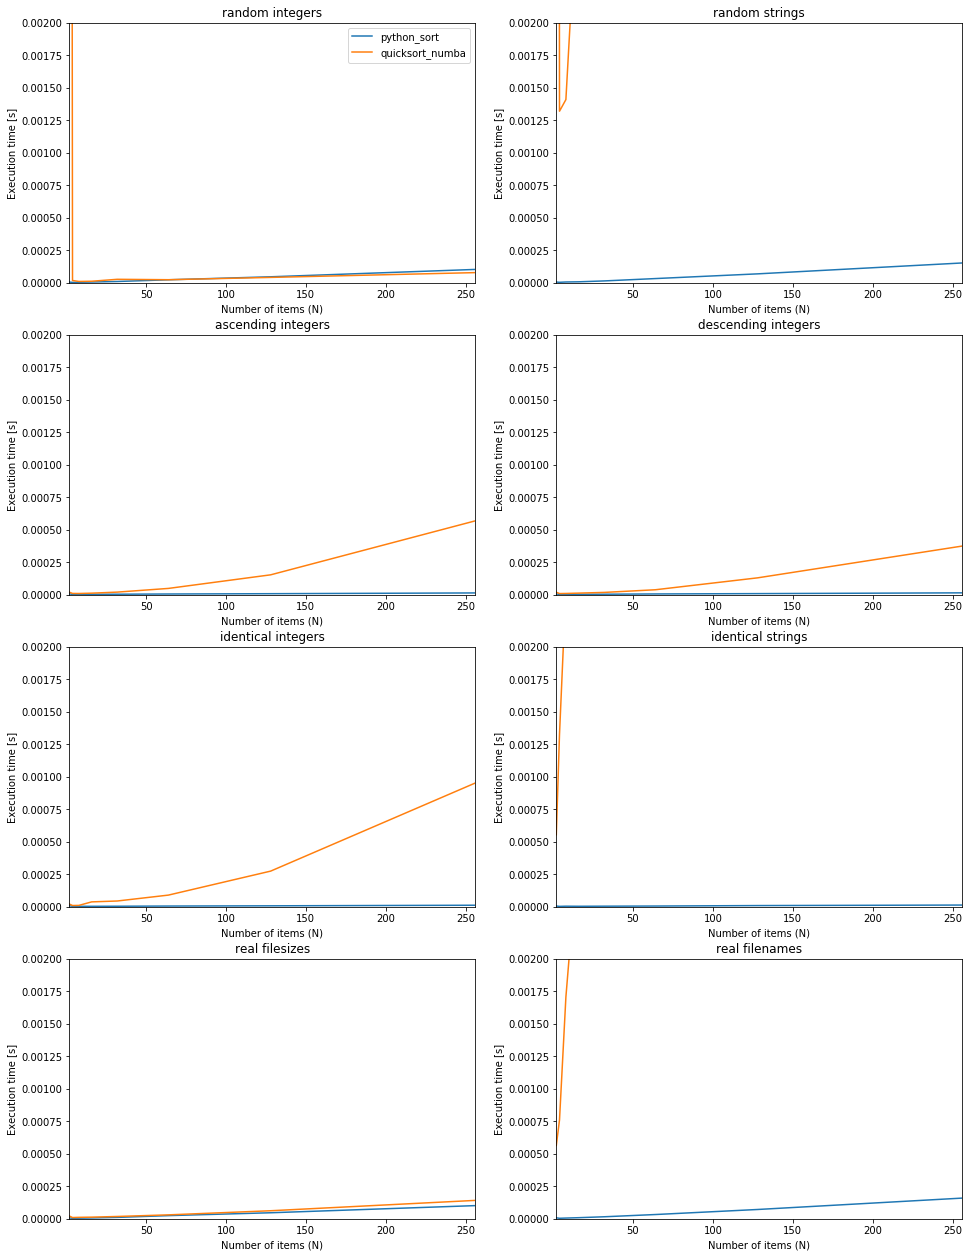

In [73]:
plot_data_versus_algorithms(algorithms=native_sorts, ymax=0.002, max_n=256);



TODO: algo compare with theory
for each sort function, plot results acrosss N on different input data distributions
max_n=1000000, except insertion sort
Use a helper function for each plot
Make comments for each, compared with expected

MAYBE: find values for c for fitting the (expected) O() bounds, insert into plot as reference
Should be done using an optimizer. Report the error (distance-squared?)?

TODO: algo comparison
For each data type, plots execution times for all sorting functions


TODO: Numbas improvement
for each data type, plot versus original/numpy/Python
, plot improvement over original

## Discussion

Discuss your results in light of the expectations from the theoretical runtime analysis we performed in class for different types of test data. Comment on unexpected or surprising results. Try to interpret your results.


Large differences even within same polyminoal class 
Improvements that exist to algorithms for improving bad cases

## Conclusions